Wage and Employment Scatter Plot Example

In [1]:
%config Completer.use_jedi = False
import pandas as pd
import numpy as np
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt

import os
os.chdir('/home/brian/Documents/econ_data/bd_CPS/')
from bd_CPS_details import ValueLabels
cbsa_names = ValueLabels['CBSA']
os.chdir('/home/brian/Documents/CPS/data/clean/')

cmap = {'South': 'blue', 'Northeast': 'crimson', 
        'Midwest': 'orange', 'West': 'limegreen'}

cols = ['YEAR', 'MONTH', 'AGE', 'CBSA', 'RHRWAGE', 
        'PWORWGT', 'BASICWGT', 'PWSSWGT', 'LFS', 
        'GTCBSASZ', 'REGION', 'FTLF', 'UNIONMEM',
        'EDUC', 'FEMALE', 'FORBORN', 'WBHAO']

emp = lambda x: np.where(x.LFS == 'Employed', 1, 0)
empsh = lambda x: np.average(x.EMP, weights=x.BASICWGT)

def binned_wage(group, wage_var='RHRWAGE', percentile=0.5, 
                bins=list(np.arange(0, 300, 0.5)), 
                bin_size=0.5, weight='PWORWGT'):
    '''
    Return BLS-styled binned decile/percentile wage
    '''
    bin_cut = lambda x: pd.cut(x[wage_var], bins, include_lowest=True)
    cum_sum = lambda x: x[weight].cumsum()
    df = (group.sort_values(wage_var)
               .assign(WAGE_BIN = bin_cut, CS = cum_sum))
    pct_wgt = df[weight].sum() * percentile
    pct_bin = df.iloc[df['CS'].searchsorted(pct_wgt)].WAGE_BIN
    wgt_btm, wgt_top = (df.loc[df['WAGE_BIN'] == pct_bin, 'CS']
                          .iloc[[0, -1]].values)
    if pct_bin.left <= 0:
        pct_value = 0
    elif wgt_btm == wgt_top:
        pct_value = df.iloc[df['CS'].searchsorted(pct_wgt)].RHRWAGE
    else:
        pct_value = ((((pct_wgt - wgt_btm) / 
                       (wgt_top - wgt_btm)) * bin_size) + pct_bin.left)
    return pct_value

In [2]:
years = range(2019, 2020)
data = pd.concat([(pd.read_feather(f'cps{y}.ft', columns=cols)
                     .assign(EMP = emp)
                     .query('CBSA != 0 and GTCBSASZ >= 5')
                     .astype({'CBSA': int}))
                  for y in years])

In [3]:
dfy = pd.DataFrame()
df = data
ages = [(18, 64)]
for age in ages:
    emp1 = (df.query('@age[0] <= AGE <= @age[1]')
              .groupby('CBSA').apply(empsh))

    dfy[f'Employment Rate, {age[0]}-{age[1]}'] = emp1 * 100

dfy['Pop'] = (df.groupby('CBSA').PWSSWGT.sum()
              / 12).round(-2)

dfy['Size'] = dfy.Pop / 50_000

group = df.groupby(['CBSA', 'REGION']).MONTH.count()
colors = {k: v for k, v in group[group > 0]
          .groupby(level=0).head(1).index.values}

dfy['Region'] = dfy.index.map(colors)

dfy['Color'] = dfy['Region'].map(cmap)

dfy['Name'] = dfy.index.map(cbsa_names)

dfw = df.query('RHRWAGE > 0 and FTLF == "Full-time" and '+
               '(@ages[0][0] <= AGE <= @ages[0][1])')
for p in [25]:
    wp = dfw.groupby('CBSA').apply(binned_wage, percentile=p/100)
    dfy[f'Real Wage, {p}th Percentile'] = wp

dfy = dfy.sort_values('Size', ascending=False)

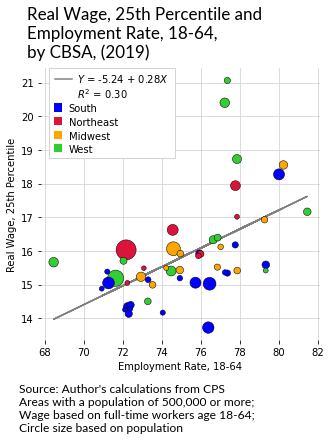

In [4]:
# Scatter plot of epop and first decile wage
y_var = 'Real Wage, 25th Percentile'
x_var = 'Employment Rate, 18-64'

# Scatter plot of epop and first decile wage
res = dfy
y = res[y_var]
x = res[x_var]

r2 = np.corrcoef(x, y)[0, 1]**2
fit = np.polyfit(x, y, 1)

fig, ax = plt.subplots()

res.plot(kind='scatter', x=x_var, y=y_var, s='Size', ax=ax,
          zorder=5, color=res['Color'], ec='black', lw=0.5, figsize=(5, 5))
plt.grid(color='lightgray', zorder=0)
plt.plot(x, np.poly1d(fit)(x), color='gray', zorder=3)
text = f'$Y$ = {fit[1]:.2f} + {fit[0]:.2f}$X$\n$R^2$ = {r2:.2f}'
plt.text(0.13, 0.89, text, transform=ax.transAxes)
plt.plot([0.05, 0.11], [0.96, 0.96], color='gray', transform=ax.transAxes)
title = f'{y_var} and\n{x_var},\nby CBSA, (2019)'
plt.text(-0.05, 1.04, title, size=17, fontname='Lato', transform=ax.transAxes)
footer = ("Source: Author's calculations from CPS\n"+
          'Areas with a population of 500,000 or more;\n'+
          'Wage based on full-time workers age 18-64;\n'+
          'Circle size based on population')
plt.text(-0.08, -0.16, footer, size=12, fontname='Lato', transform=ax.transAxes, va='top')

ax.add_patch(Rectangle((0.03, 0.67), 0.45, 0.33, fc='white', ec='lightgray', zorder=2, transform=ax.transAxes))

for i, (region, color) in enumerate(cmap.items()):
    y = 0.84 - (i/20)
    ax.add_patch(Rectangle((0.045, y), 0.03, 0.03, fc=color, transform=ax.transAxes, zorder=3))
    ax.text(0.1, y, region, transform=ax.transAxes)
for spine in ['top', 'left', 'right', 'bottom']:
    ax.spines[spine].set_visible(False)
plt.xlabel(x_var)
plt.ylabel(y_var);